In [2]:
import numpy as np
import pandas as pd
import quantstats as qs
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt

from pypfopt.risk_models import sample_cov
from pypfopt.expected_returns import mean_historical_return

from robustcov.utils import init_mu_cov
from robustcov.runner import PortfolioCreator
from robustcov.optimizers import ConvexOptimizer
from robustcov.optimizers import NCOOptimizer


qs.extend_pandas()


In [3]:
df = pd.read_csv(Path('..') / 'data' / 'indices.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df = df.set_index('Date')


# convert price history to expected returns and covariance matrix
mu = mean_historical_return(df).values
cov = sample_cov(df).values


Data is extremely huge in a sense of creating portfolio of all of the stocks. 
My computer is really slow for this task, so i cluster indexes by countries
and try to answer the following question: if i could invest in any country, 
which would i choose?

### Country clustering

In [4]:
names = df.columns.tolist() 
countries = np.array([i.split(':')[0] for i in names])
unique_countries, counts = np.unique(countries, return_counts=True)

df['sample'] = np.where(df.index < '2020-06-01', 'train', 'test')

In [7]:
def calc_stats(returns, weights, country, sample):
    weighted_returns = returns.mul(weights.T.mean(axis=1).values, axis=1)
    portfolio_returns = weighted_returns.sum(axis=1)

    return {
        'sample': sample,
        'country': country,
        'sharpe': portfolio_returns.sharpe(),
        'cumreturn': (1 + portfolio_returns).prod(),
        'win_rate': qs.stats.win_rate(portfolio_returns),
        'avg_win': qs.stats.avg_win(portfolio_returns),
        'consecutive_wins': qs.stats.consecutive_wins(portfolio_returns),
        'consecutive_loss': qs.stats.consecutive_losses(portfolio_returns),
        'max_drawdown': qs.stats.max_drawdown(portfolio_returns),
        'expected_return': qs.stats.expected_return(portfolio_returns),
        '1st_percentile_loss': qs.stats.outlier_loss_ratio(portfolio_returns),
        '99st_percentile_win': qs.stats.outlier_win_ratio(portfolio_returns),
        'profit_factor': qs.stats.profit_factor(portfolio_returns)
    }, portfolio_returns


In [10]:


train = df[df['sample'] == 'train']
test = df[df['sample'] == 'test']
train.pop('sample')
test.pop('sample')

statistics = []
portf_train_returns = {}
portf_test_returns = {}

for n, country in enumerate(unique_countries):

    print(f'{n}/{len(unique_countries)}', end='\r')
    country_mask = countries == country
    stocks = train.loc[:, country_mask]
    buy_and_hold = stocks.pct_change().mean(axis=1)

    mu = mean_historical_return(stocks).values
    cov = sample_cov(stocks).values

    if len(mu) < 4:
        print(country, 'skipped')
        continue

    optimizers = [
        # ConvexOptimizer()
        NCOOptimizer(max_clusters=len(cov) // 2)
    ]

    estimator = PortfolioCreator(
        min_var_portf=False,
        optimizers=optimizers,
        print_every=False,
        bandwidth=1,
        trials=10
    )

    results = estimator.estimate(mu, cov)
    weights = pd.DataFrame(results).T

    train_returns = train.loc[:, country_mask].pct_change()
    test_returns = test.loc[:, country_mask].pct_change()

    train_stats, train_returns = calc_stats(train_returns, weights, country, 'train')
    test_stats, test_returns = calc_stats(test_returns, weights, country, 'test')

    statistics.append(train_stats)
    statistics.append(test_stats)
    
    portf_train_returns.update({country: train_returns})
    portf_test_returns.update({country: test_returns})


Austria skipped
Botswana skipped
Bulgaria skipped
Colombia skipped
Croatia skipped
Egypt skipped
Greece skipped


/Users/tomatoparetogmail.com/ds/robust_variance/venv/lib/python3.8/site-packages/quantstats/stats.py:96: RuntimeWarning: invalid value encountered in double_scalars
  return _np.product(1 + returns) ** (1 / len(returns)) - 1


Hungary skipped
Kenya skipped
Malaysia skipped
Malta skipped
Norway skipped
Pakistan skipped
Philippines skipped
Poland skipped
Singapore skipped
Slovenia skipped
Taiwan skipped
Thailand skipped
Tunisia skipped
Ukraine skipped


# Strategies

### Maximum sharpe portfolio

Once we obtained weights of portfolios as well as descriptive statistics, 
we can have a look at what assets did optimizer choose to invest:

In [28]:
stats = pd.DataFrame(statistics)
train = stats[stats['sample'] == 'train'].sort_values('sharpe', ascending=False)
train.head()

,sample,country,sharpe,cumreturn,win_rate,avg_win,consecutive_wins,consecutive_loss,max_drawdown,expected_return,1st_percentile_loss,99st_percentile_win,profit_factor
62,train,Sweden,3.687382,1.435659,0.604344,0.000625,14,15,-0.014555,0.000165,3.076935,3.050425,1.827094
42,train,Mauritius,3.518057,4.853203,0.584623,0.002553,17,10,-0.064935,0.000720,3.657941,5.404416,2.064959
70,train,United states,3.284667,1.481130,0.588772,0.000730,16,8,-0.011462,0.000179,3.452804,3.158798,1.718821
2,train,Australia,2.936766,1.552464,0.588853,0.000908,12,8,-0.017102,0.000200,3.052714,3.150904,1.605296
8,train,Canada,2.855246,1.284091,0.583524,0.000528,11,11,-0.009838,0.000114,3.240602,3.164844,1.592751


We can see that the highest value of sharpe ratio is for Sweden,
Mauritius, US. Lets answer the following question: 
If we decided to invest, using optimizer's strategy, how would our portfolio 
look like today? 

In [31]:
test = stats[stats['sample'] == 'test']

test[test['country']\
    .isin(['Sweden', 'Mauritius', 'United states', 'Australia', 'Canada'])]\
    .sort_values('sharpe', ascending=False)


,sample,country,sharpe,cumreturn,win_rate,avg_win,consecutive_wins,consecutive_loss,max_drawdown,expected_return,1st_percentile_loss,99st_percentile_win,profit_factor
63,test,Sweden,4.066569,1.054844,0.645669,0.000669,11,8,-0.006465,0.000204,3.258752,3.112275,1.949912
71,test,United states,1.913807,1.037613,0.574713,0.000933,12,6,-0.010311,0.000141,3.137731,2.860118,1.360671
3,test,Australia,1.657773,1.027116,0.574713,0.000766,7,4,-0.008978,0.000102,2.902621,2.840059,1.305575
9,test,Canada,1.418491,1.016163,0.563218,0.000529,6,5,-0.003917,0.000061,3.333783,2.613218,1.261097
43,test,Mauritius,1.205438,1.081789,0.481928,0.003151,9,8,-0.083383,0.000300,4.623952,3.928499,1.271648


We can see that Sweden performed the best out of sample as well. Lets look at 
countries cumulated returns:

In [48]:
def plot_cum_returns(train, test, country):

    plt.suptitle('Cumulated returns IN and OUT of sample')
    f, ax = plt.subplots(figsize=(16, 5), ncols=2)

    ax[0].set_title('Cumulated returns in-sample')
    ax[1].set_title('Cumulated returns out-of-sample')
    
    (1 + train[country]).cumprod().plot(ax=ax[0])
    (1 + test[country]).cumprod().plot(ax=ax[1])


portf_train = pd.DataFrame(portf_train_returns)
portf_test = pd.DataFrame(portf_test_returns)

<Figure size 1000x600 with 0 Axes>

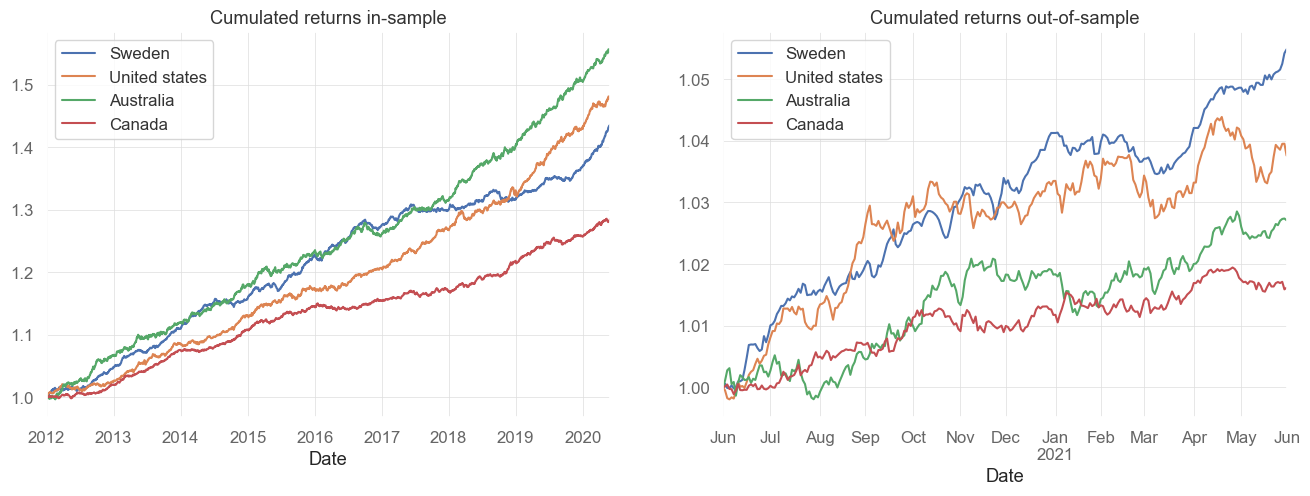

In [50]:
plot_cum_returns(portf_train, portf_test, ['Sweden', 'United states', 'Australia', 'Canada'])

### Maximum cumulated returns portfolio

Suppose we now invest in countries, judging by cumulative return in-sample:

In [55]:
train.sort_values('cumreturn', ascending=False).head()

,sample,country,sharpe,cumreturn,win_rate,avg_win,consecutive_wins,consecutive_loss,max_drawdown,expected_return,1st_percentile_loss,99st_percentile_win,profit_factor
0,train,Argentina,1.666419,2409.505430,0.546598,0.032996,14,10,-0.600498,0.003554,3.601480,3.960165,1.337398
44,train,Mexico,2.290922,103.853068,0.555044,0.012930,13,9,-0.307425,0.002117,3.229485,3.379170,1.460262
52,train,Portugal,2.271001,66.412586,0.565238,0.011749,9,9,-0.219355,0.001913,2.980034,3.325188,1.449071
66,train,Turkey,2.085361,38.379075,0.565796,0.010788,14,8,-0.179596,0.001663,3.446056,3.062733,1.406264
48,train,Netherlands,1.968999,23.559466,0.556530,0.009979,11,9,-0.217697,0.001440,3.014189,3.308165,1.381792


<Figure size 1000x600 with 0 Axes>

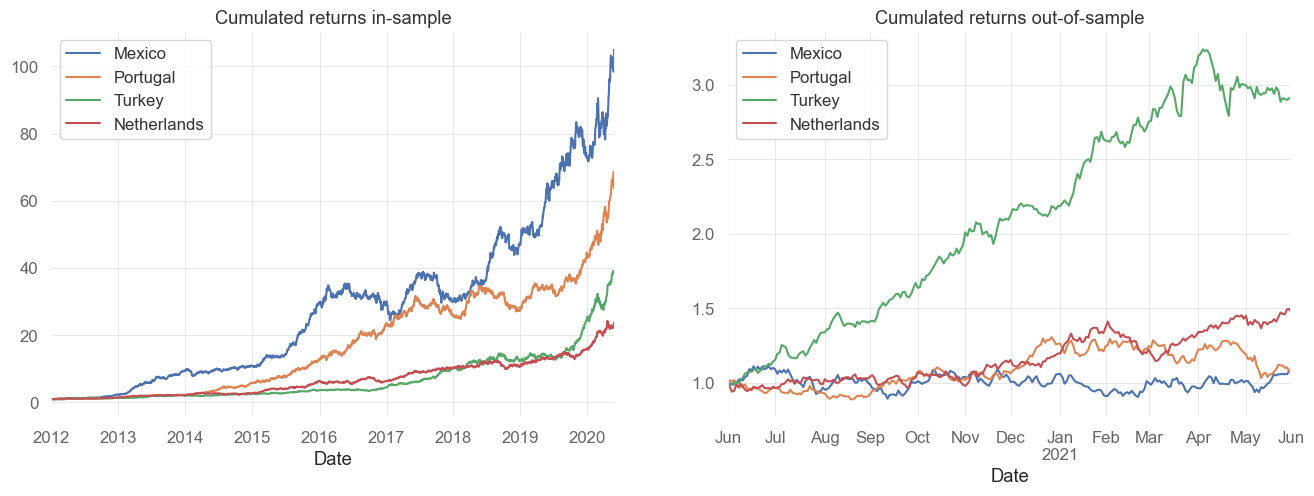

In [57]:
plot_cum_returns(portf_train, portf_test, ['Mexico', 'Portugal', 'Turkey', 'Netherlands'])

### Minimum drawdown portfolio

Now we invest in portfolios with least drawdown

In [58]:
train.sort_values('max_drawdown', ascending=False).head()

,sample,country,sharpe,cumreturn,win_rate,avg_win,consecutive_wins,consecutive_loss,max_drawdown,expected_return,1st_percentile_loss,99st_percentile_win,profit_factor
8,train,Canada,2.855246,1.284091,0.583524,0.000528,11,11,-0.009838,0.000114,3.240602,3.164844,1.592751
70,train,United states,3.284667,1.481130,0.588772,0.000730,16,8,-0.011462,0.000179,3.452804,3.158798,1.718821
38,train,Italy,1.788513,1.057130,0.541762,0.000171,10,8,-0.011582,0.000025,3.572992,4.293945,1.376957
62,train,Sweden,3.687382,1.435659,0.604344,0.000625,14,15,-0.014555,0.000165,3.076935,3.050425,1.827094
40,train,Japan,1.629273,1.335124,0.570712,0.000944,13,7,-0.016976,0.000132,3.800641,3.683284,1.326999


<Figure size 1000x600 with 0 Axes>

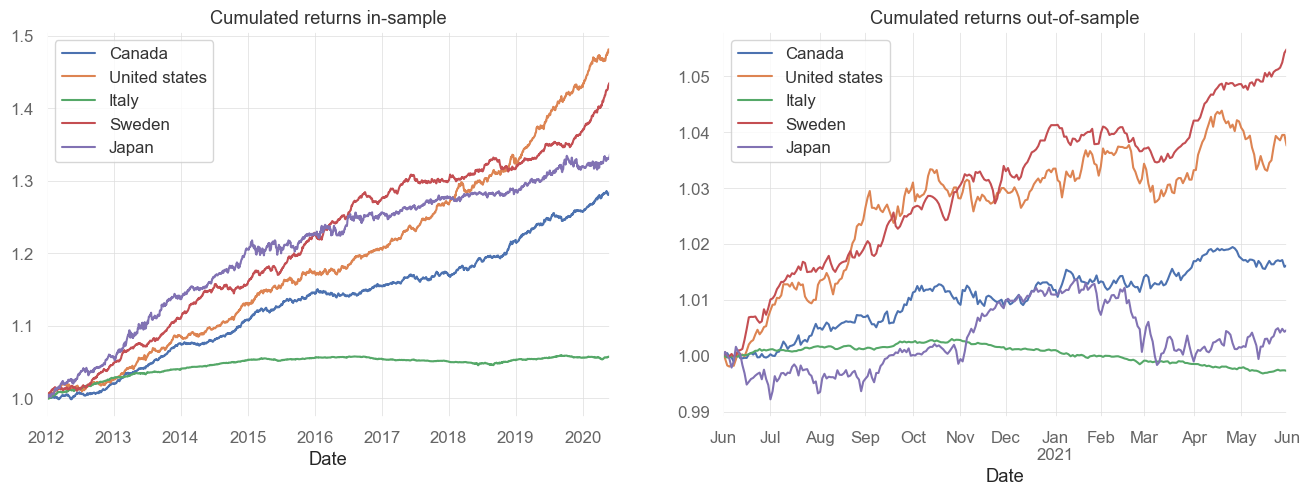

In [59]:
plot_cum_returns(portf_train, portf_test, ['Canada', 'United states', 'Italy', 'Sweden', 'Japan'])